In [1]:
import numpy as np
import pandas as pd
import stan
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/mrhome/amingk/Documents/7TPD/ActStimRL')
from Madule import utils
import arviz as az
from scipy import stats 

In [2]:
def find_mode_point(data, num_bins=1000):

    # Using guissian kernel
    kde = stats.gaussian_kde(data)
    data_kde = kde.resample()[0]

    # Discretize the data into bins
    bins = np.linspace(min(data_kde), max(data_kde), num_bins)
    digitized = np.digitize(data_kde, bins)

    # Find the mode of the digitized data
    mode_bin = stats.mode(digitized)

    # Find the midpoint of the mode bin
    mode_point = (bins[mode_bin.mode - 1] + bins[mode_bin.mode]) / 2

    return mode_point

In [3]:
simNumber = 4
#parent_dir = '/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/simulation/' # main Folder
parent_dir = '/mnt/scratch/projects/7TPD/amin/' # sractch folder
# List of subjects
subList = ['sub-004', 'sub-010', 'sub-012', 'sub-025', 'sub-026', 'sub-029', 'sub-030',
           'sub-033', 'sub-034', 'sub-036', 'sub-040', 'sub-041', 'sub-042', 'sub-044', 
           'sub-045', 'sub-047', 'sub-048', 'sub-052', 'sub-054', 'sub-056', 'sub-059', 
           'sub-060', 'sub-064', 'sub-065', 'sub-067', 'sub-069', 'sub-070', 'sub-071', 
           'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 
           'sub-081', 'sub-082', 'sub-083', 'sub-085', 'sub-087', 'sub-088', 'sub-089', 
           'sub-090', 'sub-092', 'sub-108', 'sub-109']
# number of runs
n_runs = 10
# delcare a array for saving mean parameters, (run, subjs, conds, session, para)
subs_para_mean = np.zeros([n_runs, len(subList), 2, 2, 3])
# delcare a array for saving mode parameters
subs_para_mode = np.zeros([n_runs, len(subList), 2, 2, 3])
# loop over list of participants
for run in range(1, n_runs+1):
    print(run)
    for i, subName in enumerate(subList):
        for session in [1, 2]: 
            pickelDir = parent_dir + str(simNumber) + '/' + subName + '/sess-' + str(session) + '_RL_condition_same_lr_random_reward_run'+str(run)+'.pkl'
            """Loading the pickle file of model fit from the subject directory"""
            loadPkl = utils.load_pickle(load_path=pickelDir)
            fit = loadPkl['fit']   
            # mean of estimated paraemter  for Action condition
            subs_para_mean[run-1, i, 0, session-1] = np.array([fit['alpha'][0].mean(), fit['weightAct'][0].mean(), fit['sensitivity'][0].mean()])
            # mean of estimated paraemter  for Action condition
            subs_para_mean[run-1,i, 1, session-1] = np.array([fit['alpha'][1].mean(),  fit['weightAct'][1].mean(), fit['sensitivity'][1].mean()])
            # Mode of estimated paraemter  for Action and color Conditions
            subs_para_mode[run-1,i, 0, session-1] = np.array([find_mode_point(fit['alpha'][0]), find_mode_point(fit['weightAct'][0]), find_mode_point(fit['sensitivity'][0])])
            subs_para_mode[run-1,i, 1, session-1] = np.array([find_mode_point(fit['alpha'][1]), find_mode_point(fit['weightAct'][1]), find_mode_point(fit['sensitivity'][1])])


1
2
3
4
5
6
7
8
9
10


In [4]:
# main directory
parent_dir = '/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/simulation/' 
# the grand truth parameters
subs_grand_truth = np.zeros([len(subList), 2, 2, 3])
# loop over list of participants
for i, subName in enumerate(subList):
    for session in [1,2]:
        for cond, condition in enumerate(['Act', 'Stim']): 
            dirc = parent_dir + str(simNumber) + '/' + subName +'/' + subName + '-task-design-true-param.csv'
            simulated_data = pd.read_csv(dirc)
            simulated_data_chunck = simulated_data[(simulated_data['session'] == session) & (simulated_data['block'] == condition)]
            subs_grand_truth[i, cond, session-1] = np.array([simulated_data_chunck['alpha'].unique()[0],
                                                             simulated_data_chunck['weightAct'].unique()[0],
                                                             simulated_data_chunck['beta'].unique()[0]])

In [5]:
subs_para_mean_mean =  subs_para_mean.mean(axis=0)
subs_para_mode_mean =  subs_para_mode.mean(axis=0)

Text(0.5, 1.0, 'Weighting for color condition')

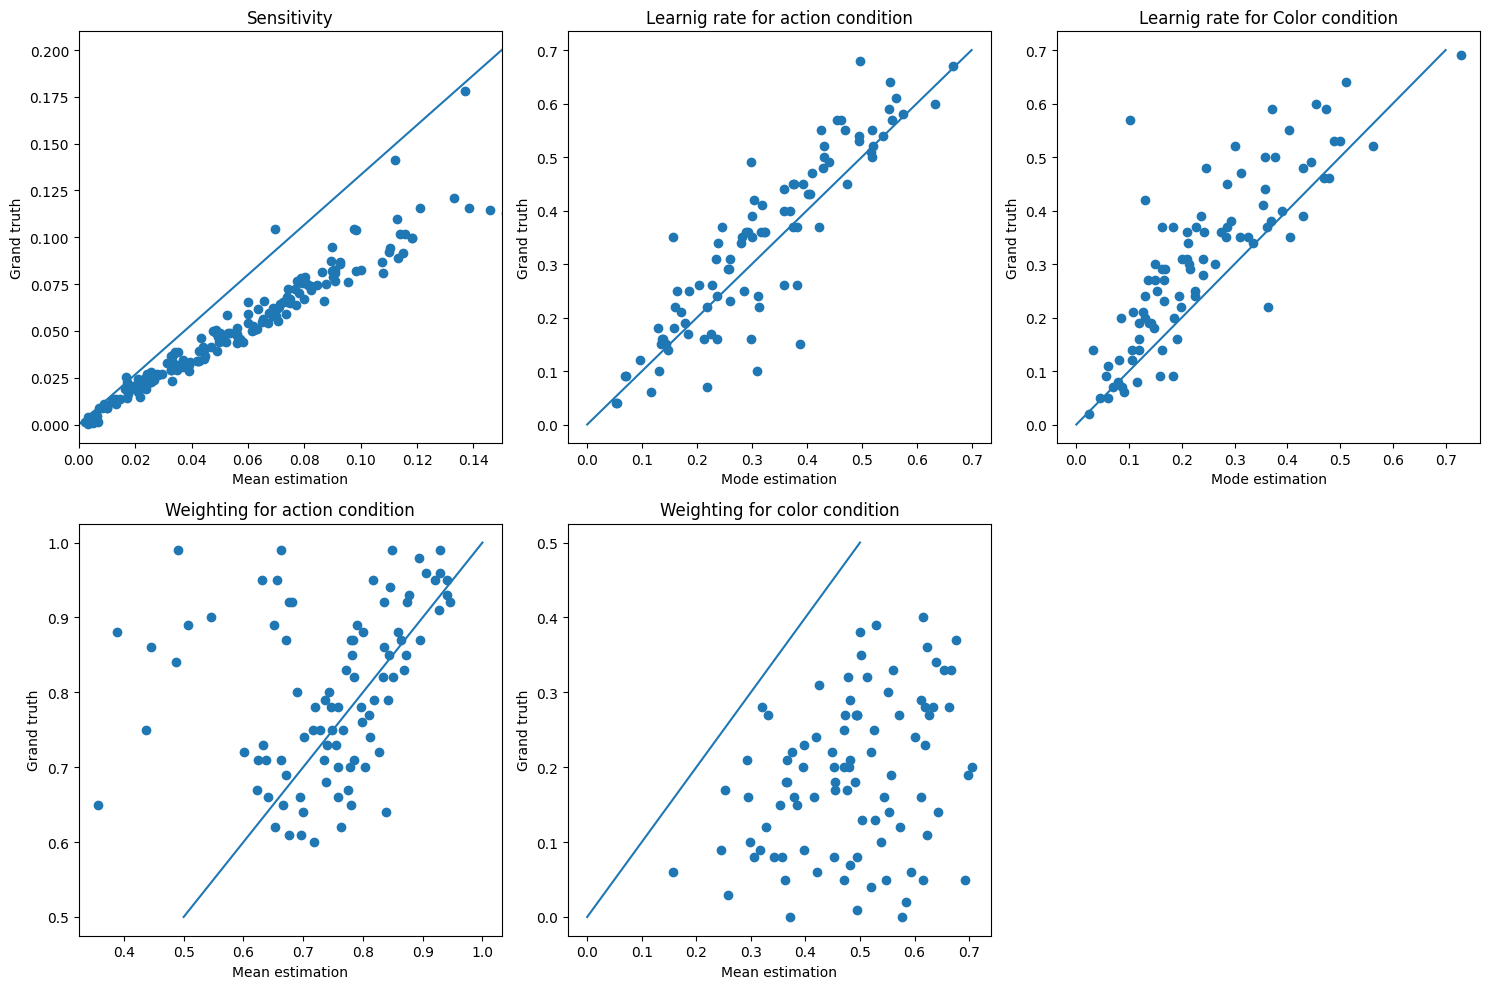

In [6]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)
rows = 2
columns =3 

# sensitivity, (subjs, conds, session, para)
fig.add_subplot(rows, columns, 1)
plt.scatter(subs_para_mode_mean[:,:,:, 2].flatten(),subs_grand_truth[:,:,:, 2].flatten())
plt.plot([.0,.15], [.0,.2])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Sensitivity')
plt.xlim(0, .15)

# learning rate
fig.add_subplot(rows, columns, 2)
plt.scatter(subs_para_mode_mean[:,0,:, 0].flatten(),subs_grand_truth[:,0,:, 0].flatten())
plt.plot([.0,.7], [.0,.7])
plt.xlabel('Mode estimation')
plt.ylabel('Grand truth')
plt.title('Learnig rate for action condition')

# learning rate
fig.add_subplot(rows, columns, 3)
plt.scatter(subs_para_mode_mean[:,1,:, 0].flatten(),subs_grand_truth[:,1,:, 0].flatten())
plt.plot([.0,.7], [.0,.7])
plt.xlabel('Mode estimation')
plt.ylabel('Grand truth')
plt.title('Learnig rate for Color condition')

# weighting
fig.add_subplot(rows, columns, 4)
plt.scatter(subs_para_mode_mean[:,0,:, 1].flatten(),subs_grand_truth[:,0,:, 1].flatten())
plt.plot([.5,1], [.5,1])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Weighting for action condition')

# weighting
fig.add_subplot(rows, columns, 5)
plt.scatter(subs_para_mode_mean[:,1,:, 1].flatten(),subs_grand_truth[:,1,:, 1].flatten())
plt.plot([0,.5], [0,.5])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Weighting for color condition')

# save figure
#fig.savefig('/home/amingk/Documents/7TPD/figures/para_reco_mode_RL_condition_same_lr_random_reward.png', dpi=300)

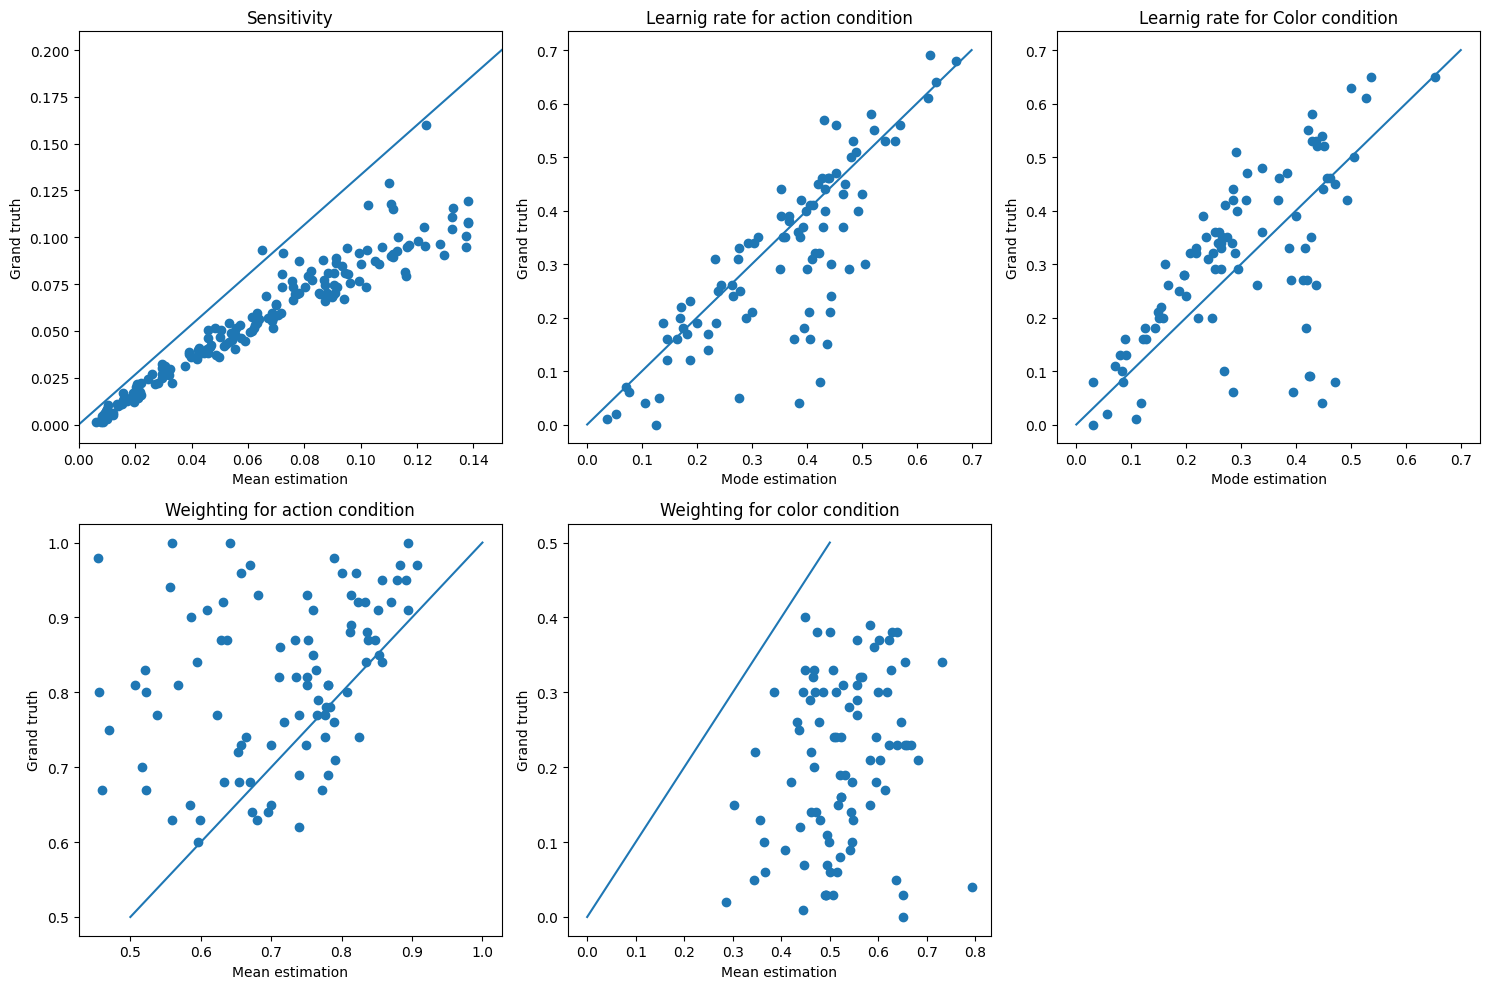

In [8]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)
rows = 2
columns =3 

# sensitivity, (subjs, conds, session, para)
fig.add_subplot(rows, columns, 1)
plt.scatter(subs_para_mean_mean[:,:,:, 2].flatten(),subs_grand_truth[:,:,:, 2].flatten())
plt.plot([.0,.15], [.0,.2])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Sensitivity')
plt.xlim(0, .15)

# learning rate
fig.add_subplot(rows, columns, 2)
plt.scatter(subs_para_mean_mean[:,0,:, 0].flatten(),subs_grand_truth[:,0,:, 0].flatten())
plt.plot([.0,.7], [.0,.7])
plt.xlabel('Mode estimation')
plt.ylabel('Grand truth')
plt.title('Learnig rate for action condition')

# learning rate
fig.add_subplot(rows, columns, 3)
plt.scatter(subs_para_mean_mean[:,1,:, 0].flatten(),subs_grand_truth[:,1,:, 0].flatten())
plt.plot([.0,.7], [.0,.7])
plt.xlabel('Mode estimation')
plt.ylabel('Grand truth')
plt.title('Learnig rate for Color condition')

# weighting
fig.add_subplot(rows, columns, 4)
plt.scatter(subs_para_mean_mean[:,0,:, 1].flatten(),subs_grand_truth[:,0,:, 1].flatten())
plt.plot([.5,1], [.5,1])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Weighting for action condition')

# weighting
fig.add_subplot(rows, columns, 5)
plt.scatter(subs_para_mean_mean[:,1,:, 1].flatten(),subs_grand_truth[:,1,:, 1].flatten())
plt.plot([0,.5], [0,.5])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Weighting for color condition')

# save figure
fig.savefig('/home/amingk/Documents/7TPD/figures/para_reco_mean_RL_condition_same_lr_switch_reward.png', dpi=300)

In [9]:
simNumber = 1
#parent_dir = '/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/simulation/' # main Folder
parent_dir = '/mnt/scratch/projects/7TPD/amin/' # sractch folder
# List of subjects
subList = ['sub-004', 'sub-010', 'sub-012', 'sub-025', 'sub-026', 'sub-029', 'sub-030',
           'sub-033', 'sub-034', 'sub-036', 'sub-040', 'sub-041', 'sub-042', 'sub-044', 
           'sub-045', 'sub-047', 'sub-048', 'sub-052', 'sub-054', 'sub-056', 'sub-059', 
           'sub-060', 'sub-064', 'sub-065', 'sub-067', 'sub-069', 'sub-070', 'sub-071', 
           'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 
           'sub-081', 'sub-082', 'sub-083', 'sub-085', 'sub-087', 'sub-088', 'sub-089', 
           'sub-090', 'sub-092', 'sub-108', 'sub-109']
# number of runs
n_runs = 10
# delcare a array for saving mean parameters
subs_para= np.zeros([len(subList), 2, 2, 3, n_runs*20000])
# loop over list of participants
for run in range(n_runs):
    print(run)
    for i, subName in enumerate(subList):
        for session in range(2): 
            pickelDir = parent_dir + str(simNumber) + '/' + subName + '/sess-' + str(session+1) + '_RL_condition_same_lr_run'+str(run+1)+'.pkl'
            """Loading the pickle file of model fit from the subject directory"""
            loadPkl = utils.load_pickle(load_path=pickelDir)
            fit = loadPkl['fit']   
            # mean of estimated paraemter  for Action condition
            subs_para[i, 0, session, 0, run*20000:(run+1)*20000] = fit['alpha'][0]
            subs_para[i, 0, session, 1, run*20000:(run+1)*20000] = fit['weightAct'][0]
            subs_para[i, 0, session, 2, run*20000:(run+1)*20000] = fit['sensitivity'][0]
            # mean of estimated paraemter for Color condition
            subs_para[i, 1, session, 0, run*20000:(run+1)*20000] = fit['alpha'][1]
            subs_para[i, 1, session, 1, run*20000:(run+1)*20000] = fit['weightAct'][1]
            subs_para[i, 1, session, 2, run*20000:(run+1)*20000] = fit['sensitivity'][1]

0
1
2
3
4
5
6
7
8
9


In [30]:
simNumber = 1
#parent_dir = '/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/simulation/' # main Folder
parent_dir = '/mnt/scratch/projects/7TPD/amin/' # sractch folder
# List of subjects
subList = ['sub-004', 'sub-010', 'sub-012', 'sub-025', 'sub-026', 'sub-029', 'sub-030',
           'sub-033', 'sub-034', 'sub-036', 'sub-040', 'sub-041', 'sub-042', 'sub-044', 
           'sub-045', 'sub-047', 'sub-048', 'sub-052', 'sub-054', 'sub-056', 'sub-059', 
           'sub-060', 'sub-064', 'sub-065', 'sub-067', 'sub-069', 'sub-070', 'sub-071', 
           'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 
           'sub-081', 'sub-082', 'sub-083', 'sub-085', 'sub-087', 'sub-088', 'sub-089', 
           'sub-090', 'sub-092', 'sub-108', 'sub-109']
# delcare a array for saving mean parameters
subs_para_general_mode= np.zeros([len(subList), 2, 2, 3])
# loop over list of participants
for i, subName in enumerate(subList):
    print(i)
    for session in range(2): 
        for condition in range(2):
            for n in range(3): # number of parameters
                subs_para_general_mode[i, condition, session, n] = find_mode_point(subs_para[i, condition, session, n])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


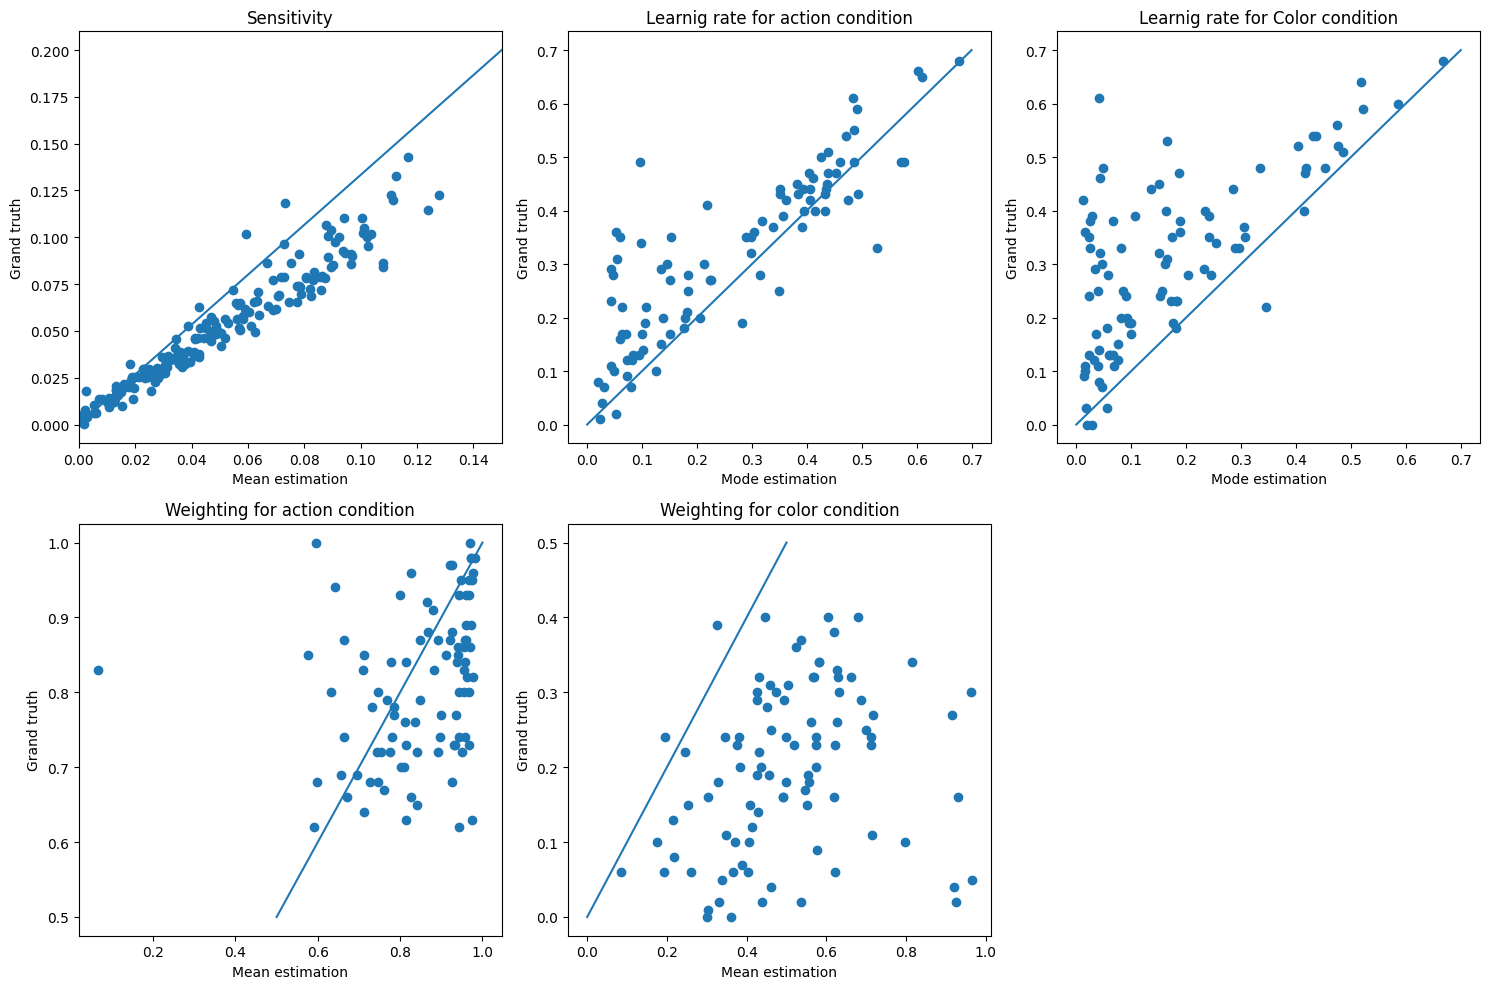

In [32]:
fig = plt.figure(figsize=(15, 10), tight_layout=True)
rows = 2
columns =3 

# sensitivity, (subjs, conds, session, para)
fig.add_subplot(rows, columns, 1)
plt.scatter(subs_para_general_mode[:,:,:, 2].flatten(),subs_grand_truth[:,:,:, 2].flatten())
plt.plot([.0,.15], [.0,.2])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Sensitivity')
plt.xlim(0, .15)

# learning rate
fig.add_subplot(rows, columns, 2)
plt.scatter(subs_para_general_mode[:,0,:, 0].flatten(),subs_grand_truth[:,0,:, 0].flatten())
plt.plot([.0,.7], [.0,.7])
plt.xlabel('Mode estimation')
plt.ylabel('Grand truth')
plt.title('Learnig rate for action condition')

# learning rate
fig.add_subplot(rows, columns, 3)
plt.scatter(subs_para_general_mode[:,1,:, 0].flatten(),subs_grand_truth[:,1,:, 0].flatten())
plt.plot([.0,.7], [.0,.7])
plt.xlabel('Mode estimation')
plt.ylabel('Grand truth')
plt.title('Learnig rate for Color condition')

# weighting
fig.add_subplot(rows, columns, 4)
plt.scatter(subs_para_general_mode[:,0,:, 1].flatten(),subs_grand_truth[:,0,:, 1].flatten())
plt.plot([.5,1], [.5,1])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Weighting for action condition')

# weighting
fig.add_subplot(rows, columns, 5)
plt.scatter(subs_para_general_mode[:,1,:, 1].flatten(),subs_grand_truth[:,1,:, 1].flatten())
plt.plot([0,.5], [0,.5])
plt.xlabel('Mean estimation')
plt.ylabel('Grand truth')
plt.title('Weighting for color condition')

# save figure
fig.savefig('/home/amingk/Documents/7TPD/figures/para_reco_global_mode_RL_condition_same_lr.png', dpi=300)